# Schneider Electric Hackathon
## Data Science Challenge
### Team 30: Rubén Cuervo,  Elliot González & Eduard Ruiz 

## Importing the libraries

In [1]:
pip install  PyPDF4

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
import PyPDF4
import os
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Useful functions for the project

In [4]:
def labelizar(col):
    col_list=list(col)
    labels={}
    for i in range(len(col_list)):
        if col_list[i] in labels:
            next
        else:
            labels[col_list[i]]=len(labels)
    col=col.replace(labels)
    return col, labels

def normalize(vector):
    vector=(vector-np.min(vector))/(np.max(vector)-np.min(vector))
    return vector

## Importing JSON datasets

In [5]:
# store the URL in url as 
# parameter for urlopen
url1 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first"
url2 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second"
url3 = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third"
  
# store the response of URL
response1 = urlopen(url1)
response2 = urlopen(url2)
response3 = urlopen(url3)
  
# getting data from json
data_json1 = json.loads(response1.read())
data_json2 = json.loads(response2.read())
data_json3 = json.loads(response3.read())
json_df1 = pd.DataFrame(data_json1)
json_df2 = pd.DataFrame(data_json2)
json_df3 = pd.DataFrame(data_json3)

# Concatening all json datagrames
json_df = pd.concat([json_df1, json_df2, json_df3])
pop_col_json = json_df.pop('')
json_df.shape

(28501, 23)

In [6]:
display(json_df)

,CITY ID,CONTINENT,City,DAY,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,EPRTRSectorCode,FacilityInspireID,MONTH,...,countryName,eprtrSectorName,facilityName,max_temp,max_wind_speed,min_temp,min_wind_speed,pollutant,reportingYear,targetRelease
0,4c325d62c064477ef17b4c6e4437e121,EUROPE,Europoort Rotterdam,2,1,4(a),Chemical installations for the production on a...,4,NL.RIVM/000019070.FACILITY,3,...,Netherlands,Chemical industry,Indorama Ventures Europe BV,13.256816011792559,11.019328717116156,14.696895445152332,20.899761591708206,Carbon dioxide (CO2),2020,AIR
1,f5e609e7095f91cc8ce9ed6d8e774a0d,EUROPE,RION,3,2,3(c),Installations for the production of cement cli...,3,EL.CAED/100075.FACILITY,2,...,Greece,Mineral industry,TITAN CEMENT S.A. - DREPANO PLANT,4.528859186447803,14.5123950384412,9.219003402711184,23.243402867192145,Nitrogen oxides (NOX),2019,AIR
2,cfab1ba8c67c7c838db98d666f02a132,EUROPE,--,1,12,1(c),Thermal power stations and other combustion in...,1,UK.CAED/BEISOffsh-Cormorant-Alpha.FACILITY,9,...,United Kingdom,Energy sector,Cormorant Alpha,10.669132597893881,20.26217117993502,14.715465115792192,23.956529199327292,Nitrogen oxides (NOX),2009,AIR
3,95b4e51f7b662598134e1eb956407c74,EUROPE,DRIZZONA,17,1,7(a),Installations for the intensive rearing of pou...,7,IT.CAED/260342003.FACILITY,10,...,Italy,Intensive livestock production and aquaculture,SOCIETA' AGRICOLA SPARAVALLE DI FERRARI GIUSEP...,7.095681595088376,18.28354666681811,13.582024001859644,26.69626609353847,Methane (CH4),2014,AIR
4,f4433be3b1bfaeeb0633eb65d04b1325,EUROPE,Lünen,6,0,5(a),Installations for the recovery or disposal of ...,5,https://registry.gdi-de.org/id/de.nw.inspire.p...,9,...,Germany,Waste and wastewater management,Biomassekraftwerk Lünen GmbH,9.886774464050356,13.75940846376134,14.00622637509683,24.768932565830674,Carbon dioxide (CO2),2015,AIR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9496,2d4776365b33d5f1be53ea4606e2c79c,EUROPE,LARNAKA,1,0,1(c),Thermal power stations and other combustion in...,1,CY.CAED/0030030000.FACILITY,1,...,Cyprus,Energy sector,"Electricity Authority of Cyprus, Vassilikos Po...",13.34580070979159,13.475987983553544,17.148326520153717,22.85253008379323,Carbon dioxide (CO2),2008,AIR
9497,020b11bf06b96aae1dd910a56674a8aa,EUROPE,Naantali,19,0,1(c),Thermal power stations and other combustion in...,1,http://paikkatiedot.fi/so/1002031/pf/Productio...,12,...,Finland,Energy sector,"Turun Seudun Energiantuotanto Oy, Naantalin vo...",3.820281499959616,8.815938780886254,5.657106835772357,20.55378092877372,Nitrogen oxides (NOX),2008,AIR
9498,84afdc8367dfd9124e8b8f994e986fe9,EUROPE,Ptuj,10,2,5(d),Landfills (excluding landfills of inert waste ...,5,SI.ARSO/000000037.FACILITY,8,...,Slovenia,Waste and wastewater management,"Javne službe Ptuj, Odlagališče nenevarnih odpa...",17.28536462543226,14.793298049775357,21.538440790883374,20.411497765443265,Methane (CH4),2010,AIR
9499,09ad69bcf41256f40be3314a33e0438c,EUROPE,VIGGIANO,25,0,3(a),Underground mining and related operations,3,IT.CAED/850592002.FACILITY,1,...,Italy,Mineral industry,Centro Olio Val d'Agri,6.387198549855581,14.911317150406134,9.269075541047428,22.64719217689789,Nitrogen oxides (NOX),2014,AIR


## Importing CSV datasets

In [7]:
train_1=pd.read_csv("train1.csv", header=0,sep=",")
train_2=pd.read_csv("train2.csv", header=0,sep=";")

train_csv = pd.concat([train_1, train_2])

In [8]:
def get_codes_for_labels(labels, codes):
    dict_codes = {}
    for idx in range(len(codes)):
        dict_codes[labels[idx]] = codes[idx]

    return dict_codes

In [9]:
codes_EPRTR = list(json_df['EPRTRAnnexIMainActivityCode'])
labels_EPRTR = list(json_df['EPRTRAnnexIMainActivityLabel'])
codes_EPRTR_dict = get_codes_for_labels(labels_EPRTR, codes_EPRTR)

codes_EPRTR_sector = list(json_df['EPRTRSectorCode'])
labels_EPRTR_sector = list(json_df['eprtrSectorName'])
codes_EPRTRsector_dict = get_codes_for_labels(labels_EPRTR_sector, codes_EPRTR_sector)

In [10]:
train_csv['EPRTRAnnexIMainActivityCode'] = train_csv['EPRTRAnnexIMainActivityLabel'].replace(codes_EPRTR_dict)
train_csv['EPRTRSectorCode'] = train_csv['eprtrSectorName'].replace(codes_EPRTRsector_dict)

## Importing PDFs datasets

In [11]:
def read_pdf(pdf_name):
    pdffileobj = open(pdf_name, 'rb')
    pdfreader = PyPDF4.PdfFileReader(pdffileobj)
    pageObj = pdfreader.getPage(0)
    txt=pageObj.extractText()
    li=txt.split("\n")
    li.pop(0) # REPORT CONTAMINACIÓN
    try:
        int(li[4])
        li.pop(4) # Extra number
    except ValueError:
        pass
    li.pop(30) # METEOROLOGICAL CONDITIONS
    vals=[]
    for i in range(1,len(li),2):
        vals.append(li[i])
    return vals

In [12]:
pdfs_dir="train6"
pdfs_name=os.listdir(pdfs_dir)
pdf_dataframe=pd.DataFrame(columns=["facilityName","FacilityInspireID","countryName","CONTINENT","City","EPRTRSectorCode",
"eprtrSectorName","EPRTRAnnexIMainActivityCode","targetRelease","pollutant","emissions",
"DAY","MONTH","reportingYear","max_wind_speed","min_wind_speed","avg_wind_speed","max_temp",
"min_temp","avg_temp","DAY WITH FOGS","REPORTER NAME","CITY ID"])
for i in range(len(pdfs_name)):
    pdf_dataframe.loc[i]=read_pdf(pdfs_dir+"/"+pdfs_name[i])[1:]
pdf_dataframe

,facilityName,FacilityInspireID,countryName,CONTINENT,City,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,targetRelease,pollutant,...,reportingYear,max_wind_speed,min_wind_speed,avg_wind_speed,max_temp,min_temp,avg_temp,DAY WITH FOGS,REPORTER NAME,CITY ID
0,Millerhill Recycling & Energy Recovery Centre,UK.SEPA/200002651.Facility,United Kingdom,EUROPE,"Millerhill, Dalkeith",5,Waste and wastewater management,5(b),AIR,Nitrogen oxides (NOX),...,2019,"1,79E+15","2,2E+16","2,04E+15","1,51E+16","1,82E+15","1,71E+16",10,William Nelson,c662b4b4d859a9c224b5ac0acf221748
1,Fife Ethylene Plant,UK.SEPA/200000061.Facility,United Kingdom,EUROPE,Cowdenbeath,1,Energy sector,1(c),AIR,Carbon dioxide (CO2),...,2019,"1,52E+16","2,06E+15","1,46E+16","9,61E+15","1,33E+16","8,69E+15",19,Shawn Graham,3c563ab0d76fc84128574b5da82f769a
2,Fife Ethylene Plant,UK.SEPA/200000061.Facility,United Kingdom,EUROPE,Cowdenbeath,1,Energy sector,1(c),AIR,Carbon dioxide (CO2),...,2019,"1,52E+16","2,06E+15","1,46E+16","9,61E+15","1,33E+16","8,69E+15",19,Shawn Graham,3c563ab0d76fc84128574b5da82f769a
3,Fife Ethylene Plant,UK.SEPA/200000061.Facility,United Kingdom,EUROPE,Cowdenbeath,1,Energy sector,1(c),AIR,Nitrogen oxides (NOX),...,2019,"1,16E+16","2,18E+16","1,65E+16","8,03E+15","1,04E+16","8,94E+15",10,Aaron Johnson,3c563ab0d76fc84128574b5da82f769a
4,Alloa Glass Factory,UK.SEPA/200000073.Facility,United Kingdom,EUROPE,Alloa,3,Mineral industry,3(e),AIR,Carbon dioxide (CO2),...,2019,"1,11E+16","2,03E+16","1,6E+16","-1,9E+16","4,07E+16","1,33E+15",4,Vicki Brown,2cc8f54182c37b8907f534011ea01e6f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Dunbar Energy Recovery Facility,UK.SEPA/200002618.Facility,United Kingdom,EUROPE,"East Barns, Dunbar, East Lothian",5,Waste and wastewater management,5(b),AIR,Nitrogen oxides (NOX),...,2019,"1,93E+16","2,67E+15","1,87E+16","6,82E+15","1,37E+16","8,77E+15",1,Christopher Tate,6935acf68ac33c9c85ff634275880d97
78,Shetland Gas Plant,UK.SEPA/200002620.Facility,United Kingdom,EUROPE,Shetland,1,Energy sector,1(c),AIR,Carbon dioxide (CO2),...,2019,"1,59E+16","2,32E+16","2,11E+15","1,18E+16","1,92E+16","1,45E+16",18,James Johnson,223137a83f11fbc93f2af549579ee6ac
79,Shetland Gas Plant,UK.SEPA/200002620.Facility,United Kingdom,EUROPE,Shetland,1,Energy sector,1(c),AIR,Methane (CH4),...,2019,"1,28E+16","1,8E+16","1,4E+16","1,56E+16","2,12E+15","1,81E+15",6,Lindsey Fisher,223137a83f11fbc93f2af549579ee6ac
80,Shetland Gas Plant,UK.SEPA/200002620.Facility,United Kingdom,EUROPE,Shetland,1,Energy sector,1(c),AIR,Nitrogen oxides (NOX),...,2019,"1,35E+16","1,78E+16","1,46E+15","9,66E+15","1,26E+16","1,1E+16",19,Brian Gonzalez,223137a83f11fbc93f2af549579ee6ac


Converting the variables to floating point numbers and normalizing them (as they are in another scale).

In [13]:
# Conversion
pdf_dataframe["avg_wind_speed"]= pdf_dataframe['avg_wind_speed'].str.replace(",",".").astype('float64')
pdf_dataframe["avg_temp"] = pdf_dataframe['avg_temp'].str.replace(",",".").astype('float64')
pdf_dataframe["max_wind_speed"]= pdf_dataframe['max_wind_speed'].str.replace(",",".").astype('float64')
pdf_dataframe["max_temp"] = pdf_dataframe['max_temp'].str.replace(",",".").astype('float64')
pdf_dataframe["min_wind_speed"]= pdf_dataframe['min_wind_speed'].str.replace(",",".").astype('float64')
pdf_dataframe["min_temp"] = pdf_dataframe['min_temp'].str.replace(",",".").astype('float64')
# Normalization
pdf_dataframe["avg_wind_speed"] = normalize(pdf_dataframe["avg_wind_speed"])
pdf_dataframe["avg_temp"] = normalize(pdf_dataframe["avg_temp"])
pdf_dataframe["max_wind_speed"] = normalize(pdf_dataframe["max_wind_speed"])
pdf_dataframe["max_temp"] = normalize(pdf_dataframe["max_temp"])
pdf_dataframe["min_wind_speed"] = normalize(pdf_dataframe["min_wind_speed"])
pdf_dataframe["min_temp"] = normalize(pdf_dataframe["min_temp"])

## Merge and clean dataframes

In [14]:
total_df = pd.concat([json_df, train_csv,pdf_dataframe])

Adding labels to all categorical variables.

In [15]:
dict_pollutants = {'Nitrogen oxides (NOX)': 0, 'Carbon dioxide (CO2)': 1, 'Methane (CH4)': 2}
total_df["countryCode"], dict_countrycode=labelizar(total_df["countryName"])
total_df["EPRTRSectorNcode"],dict_sectorcode=labelizar(total_df["EPRTRSectorCode"])
total_df["FacilityInspireCode"],dict_facilitycode=labelizar(total_df["FacilityInspireID"])
total_df["cityCode"],dict_citycode=labelizar(total_df["CITY ID"])
total_df["EPRTRAnnexIMainActivityNcode"],dict_activitynode=labelizar(total_df["EPRTRAnnexIMainActivityCode"])
total_df['pollutantCode'] = total_df['pollutant'].replace(dict_pollutants)

Dropping all unnecessary variables.

In [16]:
total_df=total_df.drop("countryName",axis=1)
total_df=total_df.drop("EPRTRSectorCode",axis=1)
total_df=total_df.drop("eprtrSectorName",axis=1)
total_df=total_df.drop("FacilityInspireCode",axis=1)
total_df=total_df.drop("facilityName",axis=1)
total_df=total_df.drop("FacilityInspireID",axis=1)
total_df=total_df.drop("CONTINENT",axis=1) # All europe
total_df=total_df.drop("CITY ID",axis=1)
total_df=total_df.drop("City",axis=1)
total_df=total_df.drop("cityCode",axis=1)
total_df=total_df.drop("EPRTRAnnexIMainActivityCode",axis=1)
total_df=total_df.drop("EPRTRAnnexIMainActivityLabel",axis=1)
total_df=total_df.drop("REPORTER NAME",axis=1)
total_df=total_df.drop("targetRelease",axis=1)
total_df=total_df.drop("pollutant",axis=1)

Converting all the object types to their correspondant datatype (integer or floating point number).

In [17]:
total_df['DAY']= total_df['DAY'].astype('int64')
total_df['DAY WITH FOGS']= total_df['DAY WITH FOGS'].astype('int64')
total_df['MONTH']= total_df['MONTH'].astype('int64')
total_df['avg_temp']= total_df['avg_temp'].astype('float64')
total_df['avg_wind_speed']=total_df['avg_wind_speed'].astype('float64')
total_df['max_temp']= total_df['max_temp'].astype('float64')
total_df['max_wind_speed']=total_df['max_wind_speed'].astype('float64')
total_df['min_temp']= total_df['min_temp'].astype('float64')
total_df['min_wind_speed']=total_df['min_wind_speed'].astype('float64')
total_df['reportingYear']= total_df['reportingYear'].astype('int64')

Selecting and modifying the features

In [18]:
total_df['rng_temp']=(total_df['max_temp']-total_df['min_temp'])
total_df['rng_wind_speed']=(total_df['max_wind_speed']-total_df['min_wind_speed'])
total_df=total_df.drop("min_temp",axis=1)
total_df=total_df.drop("max_temp",axis=1)
total_df=total_df.drop("max_wind_speed",axis=1)
total_df=total_df.drop("min_wind_speed",axis=1)
total_df=total_df.drop("reportingYear",axis=1)
total_df=total_df.drop("emissions",axis=1)
total_df["avg_temp"]=normalize(total_df["avg_temp"])
total_df["avg_wind_speed"]=normalize(total_df["avg_wind_speed"])
total_df["DAY"]=normalize(total_df["DAY"])
total_df["MONTH"]=normalize(total_df["MONTH"])

In [19]:
total_df

,DAY,DAY WITH FOGS,MONTH,avg_temp,avg_wind_speed,countryCode,EPRTRSectorNcode,EPRTRAnnexIMainActivityNcode,pollutantCode,rng_temp,rng_wind_speed
0,0.037037,1,0.181818,0.620113,0.713021,0,0,0,1,-1.440079,-9.880433
1,0.074074,2,0.090909,0.263081,0.836191,1,1,1,0,-4.690144,-8.731008
2,0.000000,12,0.727273,0.515284,0.993465,2,2,2,0,-4.046333,-3.694358
3,0.592593,1,0.818182,0.480305,0.872534,3,3,3,2,-6.486342,-8.412719
4,0.185185,0,0.727273,0.583443,0.830778,4,4,4,1,-4.119452,-11.009524
...,...,...,...,...,...,...,...,...,...,...,...
77,0.370370,1,0.818182,0.032614,0.038808,2,4,6,0,0.085063,0.814738
78,0.666667,18,0.363636,0.037146,0.004351,2,2,2,1,0.057038,-0.068605
79,0.555556,6,0.272727,0.027110,0.029046,2,2,2,2,0.362000,-0.031300
80,0.074074,19,0.090909,0.034378,0.003001,2,2,2,0,0.134061,0.008692


Observing our final dataframe.

In [20]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65710 entries, 0 to 81
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DAY                           65710 non-null  float64
 1   DAY WITH FOGS                 65710 non-null  int64  
 2   MONTH                         65710 non-null  float64
 3   avg_temp                      65710 non-null  float64
 4   avg_wind_speed                65710 non-null  float64
 5   countryCode                   65710 non-null  int64  
 6   EPRTRSectorNcode              65710 non-null  int64  
 7   EPRTRAnnexIMainActivityNcode  65710 non-null  int64  
 8   pollutantCode                 65710 non-null  int64  
 9   rng_temp                      65710 non-null  float64
 10  rng_wind_speed                65710 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 6.0 MB


In [21]:
total_df.describe().round(2)

,DAY,DAY WITH FOGS,MONTH,avg_temp,avg_wind_speed,countryCode,EPRTRSectorNcode,EPRTRAnnexIMainActivityNcode,pollutantCode,rng_temp,rng_wind_speed
count,65710.00,65710.00,65710.00,65710.00,65710.00,65710.00,65710.00,65710.00,65710.00,65710.00,65710.00
mean,0.50,2.24,0.50,0.53,0.82,8.16,2.79,11.19,0.86,-3.98,-7.00
std,0.30,3.79,0.31,0.25,0.11,6.54,1.82,12.50,0.79,1.64,2.87
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-8.00,-13.97
25%,0.26,0.00,0.18,0.37,0.73,3.00,2.00,2.00,0.00,-5.16,-9.03
50%,0.48,1.00,0.55,0.54,0.82,5.00,2.00,7.00,1.00,-3.99,-7.00
75%,0.78,2.00,0.73,0.71,0.91,12.00,4.00,16.00,2.00,-2.79,-4.96
max,1.00,19.00,1.00,1.00,1.00,31.00,8.00,70.00,2.00,0.85,0.93


We check for te number of NaNs

In [22]:
total_df.isna().sum()

DAY                             0
DAY WITH FOGS                   0
MONTH                           0
avg_temp                        0
avg_wind_speed                  0
countryCode                     0
EPRTRSectorNcode                0
EPRTRAnnexIMainActivityNcode    0
pollutantCode                   0
rng_temp                        0
rng_wind_speed                  0
dtype: int64

## Models

In [23]:
y=total_df["pollutantCode"]
x=total_df.drop("pollutantCode",axis=1)

In [24]:
x

,DAY,DAY WITH FOGS,MONTH,avg_temp,avg_wind_speed,countryCode,EPRTRSectorNcode,EPRTRAnnexIMainActivityNcode,rng_temp,rng_wind_speed
0,0.037037,1,0.181818,0.620113,0.713021,0,0,0,-1.440079,-9.880433
1,0.074074,2,0.090909,0.263081,0.836191,1,1,1,-4.690144,-8.731008
2,0.000000,12,0.727273,0.515284,0.993465,2,2,2,-4.046333,-3.694358
3,0.592593,1,0.818182,0.480305,0.872534,3,3,3,-6.486342,-8.412719
4,0.185185,0,0.727273,0.583443,0.830778,4,4,4,-4.119452,-11.009524
...,...,...,...,...,...,...,...,...,...,...
77,0.370370,1,0.818182,0.032614,0.038808,2,4,6,0.085063,0.814738
78,0.666667,18,0.363636,0.037146,0.004351,2,2,2,0.057038,-0.068605
79,0.555556,6,0.272727,0.027110,0.029046,2,2,2,0.362000,-0.031300
80,0.074074,19,0.090909,0.034378,0.003001,2,2,2,0.134061,0.008692


In [25]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1,test_size=0.2)

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
rf = RandomForestClassifier(n_estimators=200,random_state=1,criterion="entropy",max_features="log2")
rf.fit(X_train, y_train)
Y_pred = rf.predict(X_test)
print("F1: ",f1_score(y_test,Y_pred,average="macro"))

F1:  0.7112428080373823


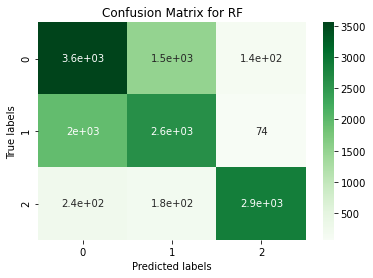

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="Greens")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix for RF')
ax.xaxis.set_ticklabels(['0', '1','2']); ax.yaxis.set_ticklabels(['0', '1','2'])
plt.show()

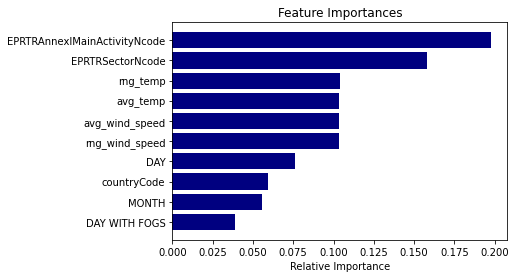

In [28]:
features = x.columns
importances = rf.feature_importances_ # Impurity-based feature importances
indices = np.argsort(importances) # Put feature with biggest importance at the top
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#000080')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [29]:
test=pd.read_csv("test_x.csv")
for i in range(len(test["EPRTRSectorCode"])):
    if test["EPRTRSectorCode"][i] in dict_sectorcode.keys():
        next
    else:
        dict_sectorcode[test["EPRTRSectorCode"][i]]=len(dict_sectorcode.values())
    if test["EPRTRAnnexIMainActivityCode"][i] in dict_activitynode.keys():
        next
    else:
        dict_activitynode[test["EPRTRAnnexIMainActivityCode"][i]]=len(dict_activitynode.values())

In [30]:
test["countryCode"]=test["countryName"].replace(dict_countrycode)
test["EPRTRSectorNcode"]=test["EPRTRSectorCode"].replace(dict_sectorcode)
test["EPRTRAnnexIMainActivityNcode"]=test["EPRTRAnnexIMainActivityCode"].replace(dict_activitynode)

In [31]:
test=test.drop("countryName",axis=1)
test=test.drop("EPRTRSectorCode",axis=1)
test=test.drop("eprtrSectorName",axis=1)
test=test.drop("FacilityInspireID",axis=1)
test=test.drop("facilityName",axis=1)
test=test.drop("CONTINENT",axis=1) # All europe
test=test.drop("CITY ID",axis=1)
test=test.drop("City",axis=1)
test=test.drop("EPRTRAnnexIMainActivityCode",axis=1)
test=test.drop("EPRTRAnnexIMainActivityLabel",axis=1)
test=test.drop("REPORTER NAME",axis=1)
test=test.drop("targetRelease",axis=1)

In [32]:
test['DAY']= test['DAY'].astype('int64')
test['DAY WITH FOGS']= test['DAY WITH FOGS'].astype('int64')
test['MONTH']= test['MONTH'].astype('int64')
test['avg_temp']= test['avg_temp'].astype('float64')
test['avg_wind_speed']=test['avg_wind_speed'].astype('float64')
test['max_temp']= test['max_temp'].astype('float64')
test['max_wind_speed']=test['max_wind_speed'].astype('float64')
test['min_temp']= test['min_temp'].astype('float64')
test['min_wind_speed']=test['min_wind_speed'].astype('float64')
test['reportingYear']= test['reportingYear'].astype('int64')

In [33]:
test['rng_temp']=(test['max_temp']-test['min_temp'])
test['rng_wind_speed']=(test['max_wind_speed']-test['min_wind_speed'])
test=test.drop("min_temp",axis=1)
test=test.drop("max_temp",axis=1)
test=test.drop("max_wind_speed",axis=1)
test=test.drop("min_wind_speed",axis=1)
test=test.drop("reportingYear",axis=1)
test["avg_temp"]=normalize(test["avg_temp"])
test["avg_wind_speed"]=normalize(test["avg_wind_speed"])
test["DAY"]=normalize(test["DAY"])
test["MONTH"]=normalize(test["MONTH"])

In [34]:
test_index=test.iloc[:,0]
test=test.drop("test_index",axis=1)

In [35]:
test

,MONTH,DAY,avg_wind_speed,avg_temp,DAY WITH FOGS,countryCode,EPRTRSectorNcode,EPRTRAnnexIMainActivityNcode,rng_temp,rng_wind_speed
0,0.636364,0.555556,0.106976,0.573356,1,8,9,22,-3.202191,-4.394782
1,0.909091,0.777778,0.453030,0.447554,0,21,10,7,-6.797013,-6.570475
2,0.727273,0.666667,0.192747,0.425928,2,0,11,2,-5.606952,-4.171204
3,0.545455,0.592593,0.432306,0.384751,2,17,10,7,-3.283012,-3.625014
4,0.454545,0.814815,0.816670,0.581617,2,10,11,2,-1.660101,-0.100534
...,...,...,...,...,...,...,...,...,...,...
24475,0.909091,0.555556,0.315924,0.203077,2,11,11,2,-3.242987,-6.871392
24476,1.000000,0.444444,0.380599,0.441018,0,5,11,2,-3.900328,-9.956941
24477,1.000000,0.407407,0.574464,0.736977,2,16,10,7,-5.651924,-8.207918
24478,0.181818,0.851852,0.389079,0.893450,1,0,15,9,-5.915440,-4.337209


In [36]:
rf_def=RandomForestClassifier(n_estimators=200,random_state=1,criterion="entropy",max_features="log2")
rf_def.fit(x, y)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=200, random_state=1)

In [37]:
predictions=rf_def.predict(test)

In [38]:
predicted=pd.DataFrame({"test_index":test_index,"pollutant":predictions})
predicted["pollutant"]

0        0
1        2
2        1
3        2
4        1
        ..
24475    1
24476    0
24477    2
24478    1
24479    1
Name: pollutant, Length: 24480, dtype: int64

In [39]:
predicted.to_csv('predictions.csv')

In [40]:
predicted.to_json('predictions.json')